In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [2]:
AAPL = pd.read_csv("/content/drive/MyDrive/Database/AAPL.csv")
TSLA = pd.read_csv("/content/drive/MyDrive/Database/TSLA.csv")
GOOG = pd.read_csv("/content/drive/MyDrive/Database/GOOG.csv")
MSFT = pd.read_csv("/content/drive/MyDrive/Database/MSFT.csv")
AMZN = pd.read_csv("/content/drive/MyDrive/Database/AMZN.csv")

### Data Proprocessing

In [3]:
def Dataset(Data, Date):

  Train_Data = Data['Adj Close'][Data['Date'] < Date].to_numpy()
  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, len(Train_Data), 5):
    try:
      Data_Train.append(Train_Data[i : i + 5])
    except:
      pass

  if len(Data_Train[-1]) < 5:
    Data_Train.pop(-1)
  
  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))


  Test_Data = Data['Adj Close'][Data['Date'] >= Date].to_numpy()
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, len(Test_Data), 5):
    try:
      Data_Test.append(Test_Data[i : i + 5])
    except:
      pass

  if len(Data_Test[-1]) < 5:
    Data_Test.pop(-1)
  
  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

### Model

In [4]:
def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

In [5]:
model = Model()

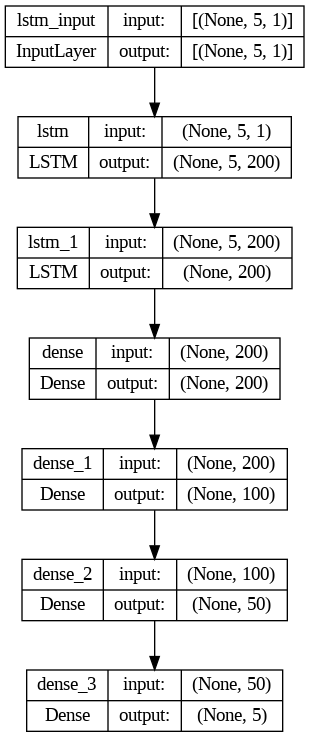

In [6]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 200)            161600    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 5)                 255       
                                                                 
Total params: 548,005
Trainable params: 548,005
Non-trai

### Custom Learning Rate

In [8]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

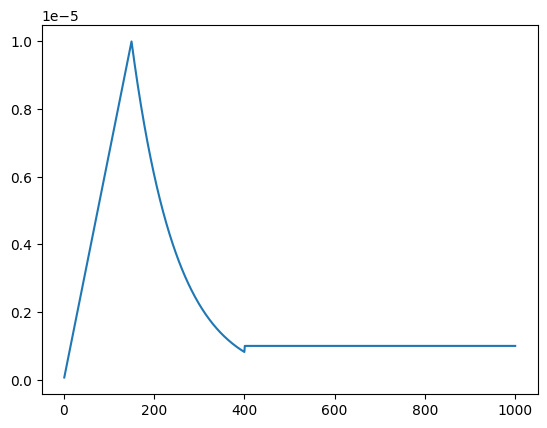

In [9]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [10]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#Apple

In [11]:
AAPL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-03-21,163.509995,166.350006,163.009995,165.380005,164.384216,95811400
1,2022-03-22,165.509995,169.419998,164.910004,168.820007,167.803497,81532000
2,2022-03-23,167.990005,172.639999,167.649994,170.210007,169.185135,98062700
3,2022-03-24,171.059998,174.139999,170.210007,174.070007,173.021881,90131400
4,2022-03-25,173.880005,175.279999,172.750000,174.720001,173.667984,80546200


In [12]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       250 non-null    object 
 1   Open       250 non-null    float64
 2   High       250 non-null    float64
 3   Low        250 non-null    float64
 4   Close      250 non-null    float64
 5   Adj Close  250 non-null    float64
 6   Volume     250 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.8+ KB


In [13]:
# Change Dtype of Date column
AAPL["Date"] = pd.to_datetime(AAPL["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [14]:
AAPL_Date = '2022-10-01'
AAPL_Train_X, AAPL_Train_Y, AAPL_Test_X, AAPL_Test_Y = Dataset(AAPL, AAPL_Date)

### Model Fitting

In [15]:
AAPL_Model = Model()

In [16]:
AAPL_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [17]:
AAPL_hist = AAPL_Model.fit(AAPL_Train_X, AAPL_Train_Y, epochs = 1000, validation_data = (AAPL_Test_X, AAPL_Test_Y), callbacks=[callback])

Epoch 1/1000
1/1 [==============================] - 4s 4s/step - loss: 23755.8242 - root_mean_squared_error: 154.1292 - val_loss: 20560.3242 - val_root_mean_squared_error: 143.3887 - lr: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - 0s 72ms/step - loss: 23755.8262 - root_mean_squared_error: 154.1292 - val_loss: 20560.2617 - val_root_mean_squared_error: 143.3885 - lr: 6.6667e-08
Epoch 3/1000
1/1 [==============================] - 0s 82ms/step - loss: 23755.7500 - root_mean_squared_error: 154.1290 - val_loss: 20560.1387 - val_root_mean_squared_error: 143.3881 - lr: 1.3333e-07
Epoch 4/1000
1/1 [==============================] - 0s 78ms/step - loss: 23755.6016 - root_mean_squared_error: 154.1285 - val_loss: 20559.9492 - val_root_mean_squared_error: 143.3874 - lr: 2.0000e-07
Epoch 5/1000
1/1 [==============================] - 0s 82ms/step - loss: 23755.3789 - root_mean_squared_error: 154.1278 - val_loss: 20559.6992 - val_root_mean_squared_error: 143.3866 - lr: 2.6667e-07
Ep

In [18]:
history_dict = AAPL_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

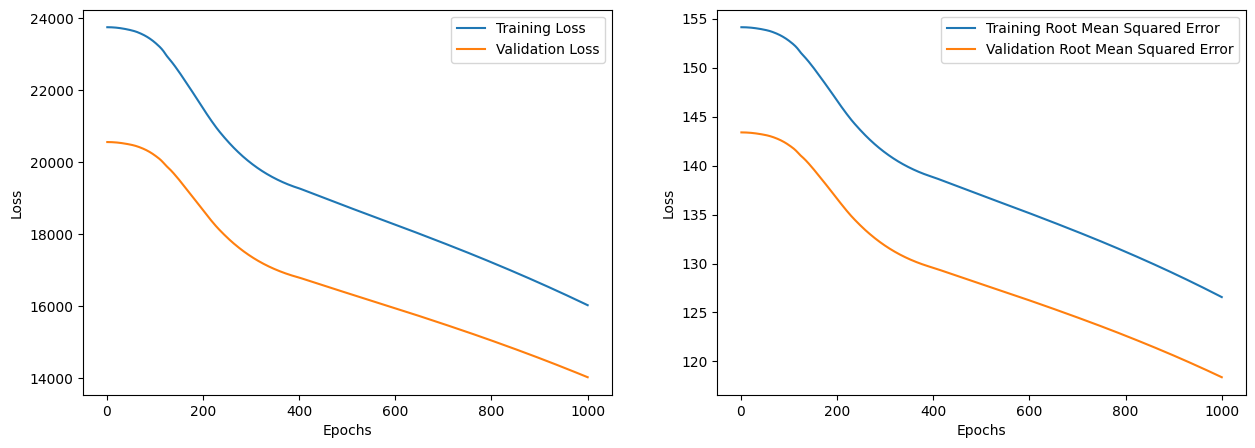

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Apple

In [20]:
AAPL_prediction = AAPL_Model.predict(AAPL_Test_X)

1/1 [==============================] - 0s 352ms/step


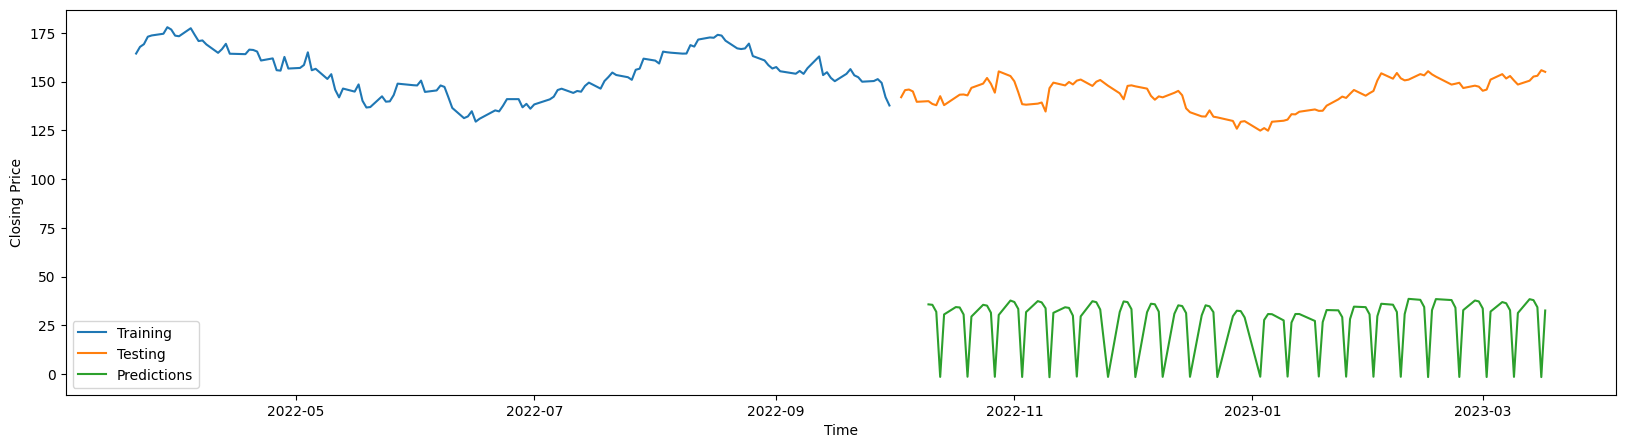

In [21]:
plt.figure(figsize=(20, 5))
plt.plot(AAPL['Date'][AAPL['Date'] < '2022-10-01'], AAPL['Adj Close'][AAPL['Date'] < '2022-10-01'], label = 'Training')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2022-10-02'], AAPL['Adj Close'][AAPL['Date'] >= '2022-10-02'], label = 'Testing')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2022-10-08'], AAPL_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [22]:
rmse = math.sqrt(mean_squared_error(AAPL_Test_Y.reshape(-1, 5), AAPL_prediction))
mape = np.mean(np.abs(AAPL_prediction - AAPL_Test_Y.reshape(-1, 5))/np.abs(AAPL_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 118.38928133888832
MAPE: 0.8165409287488762


#Tesla

In [23]:
TSLA.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-03-21,304.993347,314.283325,302.363342,307.053345,307.053345,81981600
1,2022-03-22,310.000000,332.619995,307.250000,331.326660,331.326660,105868500
2,2022-03-23,326.646667,346.899994,325.466675,333.036682,333.036682,120676200
3,2022-03-24,336.576660,341.496674,329.600006,337.973328,337.973328,68920800
4,2022-03-25,336.000000,340.600006,332.440002,336.880005,336.880005,62031600


In [24]:
TSLA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       250 non-null    object 
 1   Open       250 non-null    float64
 2   High       250 non-null    float64
 3   Low        250 non-null    float64
 4   Close      250 non-null    float64
 5   Adj Close  250 non-null    float64
 6   Volume     250 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.8+ KB


In [25]:
# Change Dtype of Date column
TSLA["Date"] = pd.to_datetime(TSLA["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [26]:
TSLA_Date = '2022-10-01'
TSLA_Train_X, TSLA_Train_Y, TSLA_Test_X, TSLA_Test_Y = Dataset(TSLA, TSLA_Date)

### Model Fitting

In [27]:
TSLA_Model = Model()

In [28]:
TSLA_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [29]:
TSLA_hist = TSLA_Model.fit(TSLA_Train_X, TSLA_Train_Y, epochs = 200, validation_data = (TSLA_Test_X, TSLA_Test_Y), callbacks=[callback])

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 79441.6328 - root_mean_squared_error: 281.8539 - val_loss: 32976.2500 - val_root_mean_squared_error: 181.5936 - lr: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 79ms/step - loss: 79441.6328 - root_mean_squared_error: 281.8539 - val_loss: 32976.2109 - val_root_mean_squared_error: 181.5935 - lr: 6.6667e-08
Epoch 3/200
1/1 [==============================] - 0s 88ms/step - loss: 79441.5156 - root_mean_squared_error: 281.8537 - val_loss: 32976.1328 - val_root_mean_squared_error: 181.5933 - lr: 1.3333e-07
Epoch 4/200
1/1 [==============================] - 0s 72ms/step - loss: 79441.2812 - root_mean_squared_error: 281.8533 - val_loss: 32976.0195 - val_root_mean_squared_error: 181.5930 - lr: 2.0000e-07
Epoch 5/200
1/1 [==============================] - 0s 83ms/step - loss: 79440.9453 - root_mean_squared_error: 281.8527 - val_loss: 32975.8594 - val_root_mean_squared_error: 181.5926 - lr: 2.6667e-07
Epoch 6

In [30]:
history_dict = TSLA_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

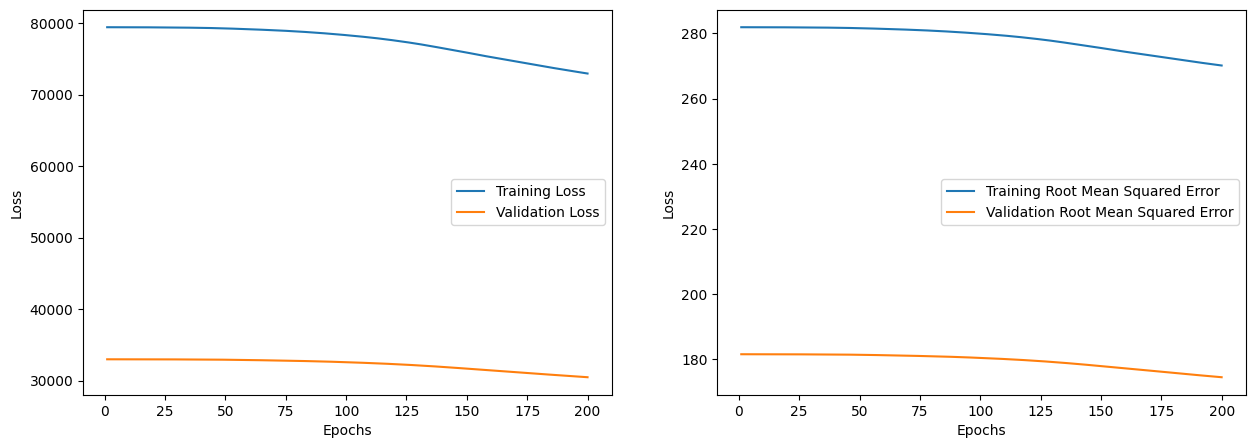

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Tesla

In [32]:
TSLA_prediction = TSLA_Model.predict(TSLA_Test_X)

1/1 [==============================] - 0s 454ms/step


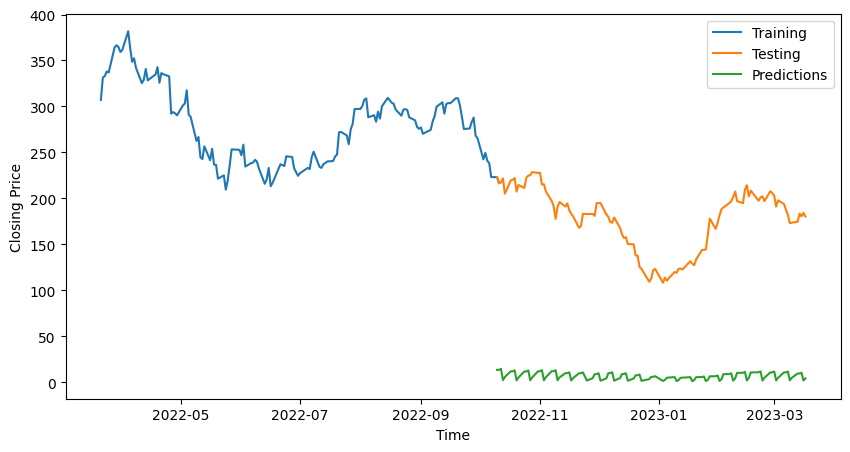

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(TSLA['Date'][TSLA['Date'] < '2022-10-12'], TSLA['Adj Close'][TSLA['Date'] < '2022-10-12'], label = 'Training')
plt.plot(TSLA['Date'][TSLA['Date'] >= '2022-10-09'], TSLA['Adj Close'][TSLA['Date'] >= '2022-10-09'], label = 'Testing')
plt.plot(TSLA['Date'][TSLA['Date'] >= '2022-10-08'], TSLA_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [34]:
rmse = math.sqrt(mean_squared_error(TSLA_Test_Y.reshape(-1, 5), TSLA_prediction))
mape = np.mean(np.abs(TSLA_prediction - TSLA_Test_Y.reshape(-1, 5))/np.abs(TSLA_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 174.54869368192217
MAPE: 0.9625551300895199


#Google

In [35]:
GOOG.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-03-21,136.847504,137.582504,134.611496,136.478500,136.478500,26632000
1,2022-03-22,136.500000,141.500000,136.500000,140.277496,140.277496,29776000
2,2022-03-23,139.138504,140.024994,138.166504,138.503494,138.503494,25302000
3,2022-03-24,139.272507,141.396500,138.039398,141.311996,141.311996,20544000
4,2022-03-25,141.753998,141.959503,139.699493,141.521500,141.521500,19270000


In [36]:
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       250 non-null    object 
 1   Open       250 non-null    float64
 2   High       250 non-null    float64
 3   Low        250 non-null    float64
 4   Close      250 non-null    float64
 5   Adj Close  250 non-null    float64
 6   Volume     250 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.8+ KB


In [37]:
# Change Dtype of Date column
GOOG["Date"] = pd.to_datetime(GOOG["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

In [38]:
GOOG_Date = '2022-10-01'
GOOG_Train_X, GOOG_Train_Y, GOOG_Test_X, GOOG_Test_Y = Dataset(GOOG, GOOG_Date)

### Model Fitting

In [39]:
GOOG_Model = Model()

In [40]:
GOOG_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
GOOG_hist = GOOG_Model.fit(GOOG_Train_X, GOOG_Train_Y, epochs = 1000, validation_data = (GOOG_Test_X, GOOG_Test_Y), callbacks = [callback])

Epoch 1/1000
1/1 [==============================] - 4s 4s/step - loss: 13432.3008 - root_mean_squared_error: 115.8978 - val_loss: 9029.8135 - val_root_mean_squared_error: 95.0253 - lr: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - 0s 79ms/step - loss: 13432.3008 - root_mean_squared_error: 115.8978 - val_loss: 9029.7939 - val_root_mean_squared_error: 95.0252 - lr: 6.6667e-08
Epoch 3/1000
1/1 [==============================] - 0s 71ms/step - loss: 13432.2646 - root_mean_squared_error: 115.8976 - val_loss: 9029.7568 - val_root_mean_squared_error: 95.0250 - lr: 1.3333e-07
Epoch 4/1000
1/1 [==============================] - 0s 85ms/step - loss: 13432.1895 - root_mean_squared_error: 115.8973 - val_loss: 9029.6992 - val_root_mean_squared_error: 95.0247 - lr: 2.0000e-07
Epoch 5/1000
1/1 [==============================] - 0s 92ms/step - loss: 13432.0791 - root_mean_squared_error: 115.8969 - val_loss: 9029.6240 - val_root_mean_squared_error: 95.0243 - lr: 2.6667e-07
Epoch 6/1000

In [ ]:
history_dict = GOOG_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Google

In [ ]:
GOOG_prediction = GOOG_Model.predict(GOOG_Test_X)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(GOOG['Date'][GOOG['Date'] < '2022-10-07'], GOOG['Adj Close'][GOOG['Date'] < '2022-10-07'], label = 'Training')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2022-10-07'], GOOG['Adj Close'][GOOG['Date'] >= '2022-10-07'], label = 'Testing')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2022-10-08'], GOOG_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [ ]:
rmse = math.sqrt(mean_squared_error(GOOG_Test_Y.reshape(-1, 5), GOOG_prediction))
mape = np.mean(np.abs(GOOG_prediction - GOOG_Test_Y.reshape(-1, 5))/np.abs(GOOG_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

#Microsoft

In [ ]:
MSFT.head()

In [ ]:
MSFT.info()

In [ ]:
# Change Dtype of Date column
MSFT["Date"] = pd.to_datetime(MSFT["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [ ]:
MSFT_Date = '2022-10-01'
MSFT_Train_X, MSFT_Train_Y, MSFT_Test_X, MSFT_Test_Y = Dataset(MSFT, MSFT_Date)

### Model Fitting

In [ ]:
MSFT_Model = Model()

In [ ]:
MSFT_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
MSFT_hist = MSFT_Model.fit(MSFT_Train_X, MSFT_Train_Y, epochs = 1000, validation_data = (MSFT_Test_X, MSFT_Test_Y), callbacks=[callback])

In [ ]:
history_dict = MSFT_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Microsoft

In [ ]:
MSFT_prediction = MSFT_Model.predict(MSFT_Test_X)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(MSFT['Date'][MSFT['Date'] < '2022-10-12'], MSFT['Adj Close'][MSFT['Date'] < '2022-10-12'], label = 'Training')
plt.plot(MSFT['Date'][MSFT['Date'] >= '2022-10-09'], MSFT['Adj Close'][MSFT['Date'] >= '2022-10-09'], label = 'Testing')
plt.plot(MSFT['Date'][MSFT['Date'] >= '2022-10-10'], MSFT_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [ ]:
rmse = math.sqrt(mean_squared_error(MSFT_Test_Y.reshape(-1, 5), MSFT_prediction))
mape = np.mean(np.abs(MSFT_prediction - MSFT_Test_Y.reshape(-1, 5))/np.abs(MSFT_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

#Amazon

In [ ]:
AMZN.head()

In [ ]:
AMZN.info()

In [ ]:
# Change Dtype of Date column
AMZN["Date"] = pd.to_datetime(AMZN["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

In [ ]:
AMZN_Date = '2022-10-01'
AMZN_Train_X, AMZN_Train_Y, AMZN_Test_X, AMZN_Test_Y = Dataset(AMZN, AMZN_Date)

### Model Fitting

In [ ]:
AMZN_Model = Model()

In [ ]:
AMZN_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [ ]:
AMZN_hist = AMZN_Model.fit(AMZN_Train_X, AMZN_Train_Y, epochs = 200, validation_data = (AMZN_Test_X, AMZN_Test_Y), callbacks=[callback])

In [ ]:
history_dict = AMZN_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Amazon

In [ ]:
AMZN_prediction = AMZN_Model.predict(AMZN_Test_X)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(AMZN['Date'][AMZN['Date'] < '2022-10-07'], AMZN['Adj Close'][AMZN['Date'] < '2022-10-07'], label = 'Training')
plt.plot(AMZN['Date'][AMZN['Date'] >= '2022-10-08'], AMZN['Adj Close'][AMZN['Date'] >= '2022-10-08'], label = 'Testing')
plt.plot(AMZN['Date'][AMZN['Date'] >= '2022-10-08'], AMZN_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [ ]:
rmse = math.sqrt(mean_squared_error(AMZN_Test_Y.reshape(-1, 5), AMZN_prediction))
mape = np.mean(np.abs(AMZN_prediction - AMZN_Test_Y.reshape(-1, 5))/np.abs(AMZN_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')